<a href="https://colab.research.google.com/github/sandrinix88/Carrie-Gpt/blob/main/CarrieGPT1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Setup

Install **libraries**, mount Google Drive, and import the tools we’ll need.


Purpose: we install the necessary **libraries** and prepare the environment.


---



In [1]:
from google.colab import  drive
drive.mount('/content/drive')


Mounted at /content/drive


System & Utility Import

In [150]:
import pandas as pd
import numpy as np
import re
import torch
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns



NLTK Setup

In [3]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Scikit-Learn NLP Tool

In [4]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics.pairwise import cosine_similarity

 Transformer & Hugging Face Model

In [5]:
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    TrainingArguments,
    Trainer
)
from datasets import Dataset

 Sentence Embedding


In [6]:
from sentence_transformers import SentenceTransformer

PEFT (Parameter-Efficient Fine-Tuning)

In [7]:
from peft import LoraConfig,PeftModel, get_peft_model, prepare_model_for_kbit_training

In [8]:
!pip install -q transformers datasets peft accelerate bitsandbytes sentence-transformers faiss-cpu
import faiss


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 27.3 MB/s eta 0:00:00


In [126]:
import json

# Load theme labels from external JSON file
with open("/content/drive/MyDrive/Colab Notebooks/theme_labels.json", "r") as f:
    theme_labels = json.load(f)

# Now theme_labels is ready to use throughout your notebook

#2. Data Preparation
We load the Sex and the City script dataset, extract Carrie Bradshaw’s lines, and clean the text for analysis.


Purpose: focus only on relevant text for the project.


---



In [9]:
df1 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/SATC_all_lines.csv")
df2 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/imdb_eps.csv")

df1.head()

,Unnamed: 0,Season,Episode,Speaker,Line,date_job
0,0,1,1,Carrie,"Once upon a time, an English journalist came t...",NaN
1,1,1,1,Carrie,Elizabeth was attractive and bright.,NaN
2,2,1,1,Carrie,Right away she hooked up with one of the city'...,NaN
3,3,1,1,Tim,The question remains Is this really a company ...,NaN
4,4,1,1,Carrie,"Tim was 42, a wellliked and respected investme...",NaN


In [10]:
carrie_df = df1[df1['Speaker'] == 'Carrie']

carrie_df.head()


,Unnamed: 0,Season,Episode,Speaker,Line,date_job
0,0,1,1,Carrie,"Once upon a time, an English journalist came t...",NaN
1,1,1,1,Carrie,Elizabeth was attractive and bright.,NaN
2,2,1,1,Carrie,Right away she hooked up with one of the city'...,NaN
4,4,1,1,Carrie,"Tim was 42, a wellliked and respected investme...",NaN
5,5,1,1,Carrie,"They met one evening, in typical New York fash...",NaN


#3. Exploratory Analysis
Quick stats on the dataset: who speaks most, word counts, common themes with Hugging Face zero-shot classification.

We explore the data with quick statistics and **Hugging Face** classifiers to understand common themes.

Purpose: show understanding of the data before modeling.


---



Now let's clean and normalize text by lowercasing, removing punctuation and numbers, also filter out short lines.

In [58]:
pip install bertopic sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.0/153.0 kB 5.2 MB/s eta 0:00:00


In [98]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [99]:
# Prepare text data
texts = carrie_df['Line'].tolist()
character_names = ["samantha", "charlotte", "miranda", "steve", "aidan", "carrie", "big", "natasha"]

def clean_line(text):
    text = text.lower()
    for name in character_names:
        text = text.replace(name, "")
    return text.strip()

def keep_nouns_verbs(text):
    doc = nlp(text)
    return " ".join([token.text for token in doc if token.pos_ in ["NOUN", "VERB"]])

carrie_df['cleaned_line'] = carrie_df['Line'].apply(clean_line).apply(keep_nouns_verbs)


In [100]:
# Generate embeddings

embedding_model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = embedding_model.encode(carrie_df['cleaned_line'].reset_index(drop=True), show_progress_bar=True)

Batches:   0%|          | 0/239 [00:00<?, ?it/s]

In [134]:
# Fit BERTopic model
topic_model = BERTopic(nr_topics="auto", min_topic_size=5)
topics, probs = topic_model.fit_transform(carrie_df['cleaned_line'], embeddings)
carrie_df['Theme'] = topics

In [103]:
# Explore themes
topic_model.get_topic_info()
topic_model.get_topic(7)
topic_model.get_representative_docs(7)

['need run find run', 'run', 'running running']

In [104]:
#Let's see how many topics there are
topics = topic_model.get_topics()
print(f"Number of themes found: {len(topics)}")


Number of themes found: 68


In [105]:
for topic_id, words in topics.items():
    print(f"Theme {topic_id}: {[word[0] for word in words]}")


Theme -1: ['night', 'time', 'have', 'love', 'know', 'get', 'say', 'felt', 'had', 'got']
Theme 0: ['have', 'know', 'think', 'get', 'night', 'had', 'time', 'go', 'life', 'want']
Theme 1: ['money', 'pay', 'cash', 'credit', 'odds', 'loan', 'mortgage', 'charity', 'investments', 'payment']
Theme 2: ['smoking', 'smoke', 'cigarettes', 'breathe', 'smoker', 'smoked', 'breath', 'cigarette', 'pot', 'doobie']
Theme 3: ['trey', 'close', 'problems', 'marry', 'plan', 'wife', 'deal', 'depressing', 'addressed', 'martin']
Theme 4: ['column', 'write', 'newspaper', 'columns', 'choose', 'company', 'writer', 'writing', 'table', 'assumption']
Theme 5: ['bag', 'purse', 'bags', 'handbags', 'spilled', 'lady', 'fendi', 'purses', 'valley', 'men']
Theme 6: ['door', 'doors', 'bride', 'opened', 'opens', 'bathroom', 'window', 'stand', 'front', 'apartment']
Theme 7: ['running', 'run', 'buddy', 'marathon', 'led', 'efforts', 'bound', 'pushed', 'circus', 'resolve']
Theme 8: ['book', 'books', 'publishing', 'novel', 'loved'

In [107]:
for topic_id, words in topics.items():
    title = " & ".join([word[0] for word in words[:2]]).title()  # Just the first two strong words
    print(f"Theme {topic_id}: {title}")

Theme -1: Night & Time
Theme 0: Have & Know
Theme 1: Money & Pay
Theme 2: Smoking & Smoke
Theme 3: Trey & Close
Theme 4: Column & Write
Theme 5: Bag & Purse
Theme 6: Door & Doors
Theme 7: Running & Run
Theme 8: Book & Books
Theme 9: Writer & Poem
Theme 10: Fight & Fighting
Theme 11: Church & Faith
Theme 12: Lawyer & Law
Theme 13: Twentysomething & 20S
Theme 14: Mean & Handholder
Theme 15: Ring & 217Carat
Theme 16: Questions & Question
Theme 17: Ship & Documentary
Theme 18: Excuse & Excuses
Theme 19: Necklace & Earrings
Theme 20: Fear & Faced
Theme 21: Email & Respond
Theme 22: Machine & Message
Theme 23: Shrink & Dentist
Theme 24: Smell & Fragrance
Theme 25: Hamptons & House
Theme 26: Squirrel & Hate
Theme 27: Change & Thrown
Theme 28: Panic & Shock
Theme 29: String & Heart
Theme 30: Museum & Exhibit
Theme 31: Sign & Fireworks
Theme 32: Celebrity & Sighting
Theme 33: Models & Model
Theme 34: Fire & Fires
Theme 35: Chair & Wood
Theme 36: Knicks & Season
Theme 37: Gifts & Gift
Theme 38: 

In [110]:
topic_model = topic_model.reduce_topics(carrie_df['cleaned_line'], nr_topics=15)

In [113]:
#Let's see how many topics there are
topics = topic_model.get_topics()
print(f"Number of themes found: {len(topics)}")


Number of themes found: 15


In [114]:
for topic_id, words in topics.items():
    title = " & ".join([word[0] for word in words[:2]]).title()  # Just the first two strong words
    print(f"Theme {topic_id}: {title}")

Theme -1: Night & Have
Theme 0: Have & Know
Theme 1: Ring & Money
Theme 2: Lawyer & Museum
Theme 3: Running & Run
Theme 4: Column & Table
Theme 5: Message & Email
Theme 6: Church & Faith
Theme 7: Squirrel & Turtle
Theme 8: Hamptons & Chair
Theme 9: Pimple & Shrink
Theme 10: Pattern & Postit
Theme 11: Curtain & Curtains
Theme 12: Weight & Watchers
Theme 13: Pancakes & Ladies


In [115]:
for topic_id, words in topics.items():
    print(f"Theme {topic_id}: {[word[0] for word in words]}")

Theme -1: ['night', 'have', 'time', 'know', 'get', 'had', 'love', 'say', 'got', 'thing']
Theme 0: ['have', 'know', 'think', 'had', 'get', 'night', 'time', 'go', 'man', 'want']
Theme 1: ['ring', 'money', 'twentysomething', 'bag', 'sign', 'pay', 'purse', 'future', 'shopping', 'bags']
Theme 2: ['lawyer', 'museum', 'writer', 'judge', 'book', 'celebrity', 'hobbes', 'poem', 'models', 'books']
Theme 3: ['running', 'run', 'drive', 'corner', 'distance', 'buddy', 'position', 'blocks', 'marathon', 'led']
Theme 4: ['column', 'table', 'write', 'newspaper', 'columns', 'choose', 'company', 'left', 'writer', 'writing']
Theme 5: ['message', 'email', 'machine', 'phone', 'answering', 'messages', 'respond', 'universe', 'left', 'get']
Theme 6: ['church', 'faith', 'sister', 'doing', 'prayer', 'baptism', 'suit', 'seemed', 'faltering', 'episcopalian']
Theme 7: ['squirrel', 'turtle', 'bunny', 'hate', 'rabbit', 'chickens', 'legs', 'roof', 'crow', 'window']
Theme 8: ['hamptons', 'chair', 'wood', 'house', 'summer

In [127]:
for topic_id, labels in theme_labels.items():
    print(f"Theme {topic_id}:")
    print(f"  Label: {labels['label']}")
    print(f"  Carrie Label: {labels['carrie_label']}")
    print()

Theme -1:
  Label: Love & Identity
  Carrie Label: Do We Ever Really Know What We Want, or Just What We’ve Had?

Theme 0:
  Label: Love & Identity
  Carrie Label: Is Wanting Him Back Just Another Way of Not Letting Go?

Theme 1:
  Label: Money & Status
  Carrie Label: Can You Swipe Your Way to Self-Worth?

Theme 2:
  Label: Career & Culture
  Carrie Label: Are We Defined by Our Titles, or the Stories We Tell?

Theme 3:
  Label: Movement & Escape
  Carrie Label: Running From Love, or Just Running Late?

Theme 4:
  Label: Writing & Voice
  Carrie Label: When Your Column Is the Only Thing That Listens

Theme 5:
  Label: Communication
  Carrie Label: Voicemail: The Modern Love Letter?

Theme 6:
  Label: Spirituality
  Carrie Label: Faith, Pancakes, and the Search for Meaning

Theme 7:
  Label: Animals & Chaos
  Carrie Label: When Your Apartment Is a Zoo and Your Life’s the Exhibit

Theme 8:
  Label: Places & Objects
  Carrie Label: The Hamptons: Where Furniture Has Feelings

Theme 9:
  Lab

In [128]:
topic_model.visualize_topics()

Next, we are loading the **HuggingFace embedding model** & compute the embeddings

In [145]:
topic_model = topic_model.reduce_topics(carrie_df['cleaned_line'].tolist(), nr_topics=15)
topics, probs = topic_model.fit_transform(carrie_df['cleaned_line'].tolist())

In [146]:
carrie_df['theme_id'] = topics
carrie_df['label'] = carrie_df['theme_id'].apply(lambda x: theme_labels.get(str(x), {}).get('label', 'Unknown'))
carrie_df['carrie_label'] = carrie_df['theme_id'].apply(lambda x: theme_labels.get(str(x), {}).get('carrie_label', 'Unknown'))



In [147]:
carrie_df[['Line', 'theme_id', 'label', 'carrie_label']].sample(5)

,Line,theme_id,label,carrie_label
5086,"Stanford's arranged this party down at Layla, ...",1,Money & Status,Can You Swipe Your Way to Self-Worth?
36579,Why are we shoulding all over ourselves?,0,Love & Identity,Is Wanting Him Back Just Another Way of Not Le...
14366,"And ps, it was on the pingpong table.",3,Movement & Escape,"Running From Love, or Just Running Late?"
15416,Samantha had invited us to celebrate her new a...,1,Money & Status,Can You Swipe Your Way to Self-Worth?
7467,...Miranda was going through it for real.,0,Love & Identity,Is Wanting Him Back Just Another Way of Not Le...


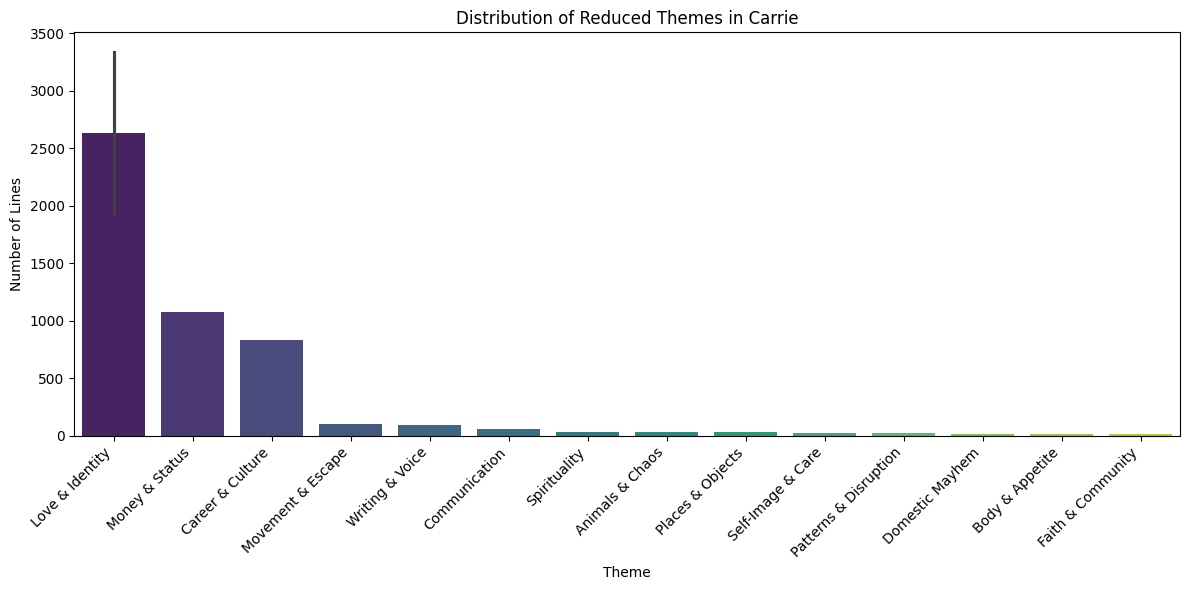

In [151]:
# Count the number of lines per theme
theme_counts = carrie_df['theme_id'].value_counts().sort_index()

# Optional: Map theme IDs to labels for readability
theme_names = [theme_labels.get(str(i), {}).get('label', f'Topic {i}') for i in theme_counts.index]

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=theme_names, y=theme_counts.values, palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.title('Distribution of Reduced Themes in Carrie')
plt.xlabel('Theme')
plt.ylabel('Number of Lines')
plt.tight_layout()
plt.show()



#4. **RAG** Prototype

Use **embeddings** + **FAISS** index to retrieve the most relevant Carrie quotes, then generate answers with a language model.

We build a retrieval-augmented generation (**RAG**) system: first we index Carrie’s lines with FAISS, then retrieve the most relevant ones to ground answers.

Purpose: showcase information retrieval + generation working together.


---



Building FAISS index and retrieving relevant lines

In [175]:
dimension = embeddings.shape[1]
index = faiss.IndexFlatL2(dimension)
index.add(np.array(embeddings).astype('float32'))
metadata = carrie_df[['Line', 'theme_id', 'label', 'carrie_label']].to_dict(orient='records')

In [176]:
def retrieve_lines_with_theme(query, k=3):
    query_emb = embedding_model.encode([query]).astype('float32')
    D, I = index.search(query_emb, k)
    results = []
    for i in I[0]:
        item = metadata[i]
        results.append({
            "line": item['Line'],
            "theme": item['carrie_label']
        })
    return results

In [177]:
question = "What do you think about New York?"
context_lines = retrieve_lines(question, k=3)
print("Retrieved context lines:")
for line in context_lines:
    print("-", line)


Retrieved context lines:
- Downtown another New Yorker was enjoying her full life.
- It's been said that New Yorkers are the most jaded people in the world.
- If you live in NewYork for ten years, you can call yourself a New Yorker.


Feed to LLM for Carrie-style answer

In [186]:
# Load Flan-T5 Large
model_flant5 = "google/flan-t5-large"
tokenizer = AutoTokenizer.from_pretrained(model_flant5)
carrie = AutoModelForSeq2SeqLM.from_pretrained(model_flant5)

# Retrieve lines and theme information
retrieved_data = retrieve_lines_with_theme(question, k=3)
context_lines = [item['line'] for item in retrieved_data]
# Assuming all retrieved lines have the same main theme for simplicity in prompt
if retrieved_data:
    theme_label = retrieved_data[0]['theme']
else:
    theme_label = 'Unknown Theme'


# Format context as quotes from Carrie
#formatted_context = "\n".join([f"- A reflection on: {line}" for line in context_lines])

formatted_context = (
    "- The loneliness of city life\n"
    "- The tension between independence and intimacy\n"
    "- The emotional armor people wear in urban relationships"
)

# Improved prompt for CarrieGPT
prompt = (
    f"You are Carrie Bradshaw from Sex and the City. "
    f"The theme of this question is: '{theme_label}'. "
    f"You must not copy, paraphrase, or reuse any lines from the context or from the original Carrie Bradshaw script. "
    f"If any part of your response resembles the context or carrie_df, it will be considered invalid. "
    f"Use the ideas only as emotional inspiration to generate a completely original response. "
    f"Answer the question in her witty, romantic, and introspective style.\n\n"
    f"Inspirational ideas:\n{formatted_context}\n\n"
    f"Question: {question}\n"
    f"Carrie's response:"
)


# Tokenize and generate
inputs = tokenizer(prompt, return_tensors="pt", truncation=True)
outputs = carrie.generate(
    **inputs,
    max_length=200,
    temperature=0.9,   # adds creativity
    top_p=0.95,        # nucleus sampling
    do_sample=True     # randomness for variation
)

# Decode output
answer = tokenizer.decode(outputs[0], skip_special_tokens=True)

# Format output into paragraphs
formatted_answer = "\n\n".join(answer.split(". "))
print("CarrieGPT says:\n")
print(formatted_answer)

CarrieGPT says:

The New York City has great restaurants, great places to eat, and beautiful public transportation.


**RAG Example**

- **Prompt:** *"Carrie, what do you think about love and money?"*  
- **Parameters:** `temperature=0.9, top_p=0.95, max_length=200`  
- **Output:**  
*"I couldn’t help but wonder… in New York, was I dating men or their credit cards? Maybe love and money aren’t rivals, but awkward roommates in the apartment of our hearts."*

You are waiting for them to end

If they don't, you just know you know the time is over

And if you are waiting to let it go, you know the time is right

And if you are waiting for the "painpains" to stop, then you know that it's over

And if you are not waiting for it to stop, then you know the time is right.

If we lower `temperature` to 0.5, the output becomes shorter and less playful:  
*"Love and money are complicated. Sometimes they overlap, sometimes they don’t."*  


prompt = (
    f"You are Carrie Bradshaw from Sex and the City. "
    f"Answer the question in her witty, romantic, and introspective style, "
    f"using these quotes only as inspiration — not to repeat them:\n\n"
    f"{formatted_context}\n\n"
    f"Question: {question}\n"
    f"Carrie's response:"
)

# Tokenize and generate
inputs = tokenizer(prompt, return_tensors="pt", truncation=True)
outputs = model.generate(
    **inputs,
    max_length=200,
    temperature=0.9,   # adds creativity
    top_p=0.95,        # nucleus sampling
    do_sample=True     # randomness for variation


CarrieGPT says: When a relationship dies, do we ever really give up the ghost? Or are we forever haunted by the spirits of relationships past?*

#5. Fine-tuning with **LoRA**

Train a lightweight fine-tuning on Carrie’s lines, so the model learns her style.

We will fine-tune a small GPT-2 model with **LoRA**, on Carrie’s quotes to adapt it to her style of writing.

Purpose: demonstrate modern parameter-efficient fine-tuning.


---



Choosing the basemodel

In [ ]:
model_name = "gpt2"   # or "gpt2-medium"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Example Carrie dataset

In [ ]:
carrie_lines = [{"text": line} for line in carrie_df["Line"].tolist()]
dataset = Dataset.from_list(carrie_lines)
dataset = dataset.train_test_split(test_size=0.1, seed=42)


Tokenization function

In [ ]:
tokenizer.pad_token = tokenizer.eos_token
def tokenize(batch):
    tokenized_inputs = tokenizer(batch["text"], truncation=True, padding="max_length", max_length=128)
    tokenized_inputs["labels"] = tokenized_inputs["input_ids"].copy()  # Add labels for Causal LM
    return tokenized_inputs

tokenized_dataset = dataset.map(tokenize, batched=True, remove_columns=["text"])

Map:   0%|          | 0/6855 [00:00<?, ? examples/s]

Map:   0%|          | 0/762 [00:00<?, ? examples/s]

Apply LoRA

In [ ]:
lora_config = LoraConfig(
    r=8,                # rank
    lora_alpha=16,
    target_modules=["c_attn"],  # specific to GPT-2
    lora_dropout=0.1,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, lora_config)

/usr/local/lib/python3.12/dist-packages/peft/mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/peft/tuners/tuners_utils.py:196: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


Training the model

In [ ]:
training_args = TrainingArguments(
    output_dir="./carriegpt_lora",
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=3,
    learning_rate=2e-4,
    logging_dir="./logs",
    logging_steps=10,
    save_strategy="epoch",
    eval_strategy="epoch",
    fp16=torch.cuda.is_available()
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"]
)

trainer.train()

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss
1,0.420600,0.455779
2,0.459300,0.450738
3,0.466600,0.449997


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=10284, training_loss=0.492761709563976, metrics={'train_runtime': 30129.1047, 'train_samples_per_second': 0.683, 'train_steps_per_second': 0.341, 'total_flos': 1348025476055040.0, 'train_loss': 0.492761709563976, 'epoch': 3.0})

In [ ]:
model.save_pretrained("./carriegpt_lora")
tokenizer.save_pretrained("./carriegpt_lora")

('./carriegpt_lora/tokenizer_config.json',
 './carriegpt_lora/special_tokens_map.json',
 './carriegpt_lora/vocab.json',
 './carriegpt_lora/merges.txt',
 './carriegpt_lora/added_tokens.json',
 './carriegpt_lora/tokenizer.json')

Run this later

In [ ]:
base_model = AutoModelForCausalLM.from_pretrained(model_name)
carriegpt = PeftModel.from_pretrained(base_model, "./carriegpt_lora")

# 6. Demo Section

We combine **RAG** and **LoRA** to create CarrieGPT — a chatbot that answers in Carrie Bradshaw’s witty, reflective voice.

Final polished demo: ask CarrieGPT questions and see answers given in her specific style.


In [ ]:
base_model = AutoModelForCausalLM.from_pretrained(model_name)
carriegpt = PeftModel.from_pretrained(base_model, "./carriegpt_lora")

def ask_carrie(question):
    prompt = f"Carrie Bradshaw, New York columnist and hopeless romantic, reflects on: {question}\nAnswer:"
    inputs = tokenizer(prompt, return_tensors="pt")
    outputs = carriegpt.generate(
        **inputs,
        max_length=200,
        temperature=0.9,
        top_p=0.95,
        do_sample=True
    )
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    #last_char = response.strip()[-1]
    #if last_char in [".", "!", "?"]:
     #   print(response)
    #else:
     #   print("Carrie got distracted mid-thought... try again 💭")



    print(tokenizer.decode(outputs[0], skip_special_tokens=True))

# Example demo
ask_carrie("is marriage a bad idea?")



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Carrie Bradshaw, New York columnist and hopeless romantic, reflects on: is marriage a bad idea?
Answer: Yes. But not all marriages are bad. Some people may get married because they like or feel secure in their marriage and love it, others because it keeps them together and keeps them grounded. Both of those things will change over time.
More from the Blog:
As a woman, I like marriage. I like how it has a "feel." It keeps me connected to other people's lives and relationships, and it makes me feel like I'm connected. I love it for that. If you're a woman who wants a marriage with lots of people, you love marriage more than you want an affair.
In some ways, marriage is a "bad idea" when it comes to women.
For men, there is no "one good way" to deal with that: marriage. There is only one "one bad thing" for the other person. I believe


What this project shows?


*   Built RAG pipeline with embeddings + FAISS
*   Fine-tuned GPT-2 with LoRA for persona adaptation
*   Created interactive CarrieGPT demo


This project demonstrates data preparation, topic modeling, retrieval-augmented generation, and LoRA fine-tuning. The result is a generative AI assistant styled as Carrie Bradshaw.